#Import Necessary Dependencies

In [43]:
# === 1. IMPORT NECESSARY LIBRARIES ===
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import os
import json

In [44]:
# === 2. FILE HANDLING: UPLOAD TEST DATASET ===

from google.colab import files
uploaded = files.upload()

Saving TestDataSet.zip to TestDataSet (2).zip


In [45]:
print(os.listdir())  # Confirm uploaded files

['.config', 'TestDataSet', 'TestDataSet (1).zip', 'Adversarial_Test_Set2', 'TestDataSet.zip', 'TestDataSet (2).zip', '__MACOSX', 'Adversarial_Test_Set1', 'Adversarial_Test_Set3', 'sample_data']


In [46]:
# Unzip the file
with zipfile.ZipFile("TestDataSet.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [47]:
import os

print(os.listdir("./TestDataSet"))  # Check extracted files


['n02708093', 'n02807133', 'n03032252', 'n02825657', 'n02840245', 'n02917067', 'n02883205', 'n02916936', 'n02859443', 'n02797295', 'n02980441', 'n02966193', 'n02814533', 'n02687172', 'n03026506', 'n02978881', 'n02823750', 'n02690373', 'n02799071', 'n02966687', 'n02948072', 'n02676566', 'n02892201', 'n02672831', 'labels_list.json', 'n03018349', 'n02808440', 'n02776631', 'n02999410', 'n02860847', 'n02791270', 'n02782093', 'n02783161', 'n02894605', 'n03016953', 'n02835271', 'n02871525', 'n02814860', 'n02804610', 'n03017168', 'n02870880', 'n02971356', 'n02909870', 'n02981792', 'n02808304', 'n02786058', 'n02950826', 'n02951358', 'n02841315', 'n02910353', 'n02793495', 'n02834397', 'n02787622', '.DS_Store', 'n02939185', 'n02837789', 'n03000134', 'n02701002', 'n02843684', 'n03028079', 'n02977058', 'n02965783', 'n02747177', 'n02790996', 'n03000684', 'n02895154', 'n02963159', 'n02692877', 'n02979186', 'n02815834', 'n02879718', 'n02795169', 'n02992529', 'n03000247', 'n02749479', 'n02704792', 'n03

# Task 1: Basics
The goal is to attack a ResNet-34 model that is trained to classify the ImageNet-1K dataset. ImageNet-1K is a well-known dataset in computer vision research with visually challenging images from 1000 classes, and networks which are trained on ImageNet typically also do well on other tasks. You can download the ResNet-34 model from TorchVision using the following command:
```
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
```

Download the attached test dataset. This is a subset of images taken from 100 classes of the ImageNet-1K dataset. The included .json file has the associated label names and ImageNet label indices. We will need to preprocess the images like this before doing anything else:
```
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms, std=std_norms) ])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)
```
Evaluate the pre-trained ResNet-34 model on this test dataset; note that to validate a prediction you will have to look at the predicted class label and match it to the corresponding index in the .json file.
Report top-1 and top-5 accuracy for this dataset. (Top-k accuracy is calculated as follows: compute the k most likely class labels according to the classifier, and return True if any of these k labels matches the ground truth.)

In [48]:
# === TASK 1: LOAD MODEL AND PREPROCESS DATA ===

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Download the pretrained resnet 34 model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()  # Set the model to evaluation model


# Define preprocessing: tensor conversion + ImageNet normalization
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])

#The provided test data is subset of images taken from 100 classes the ImageNet-1K dataset
dataset_path = os.path.join("/content", "TestDataSet")
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)


# Load the class information from the JSON file (now a list of strings)
json_path = "/content/TestDataSet/labels_list.json"
with open(json_path, 'r') as f:
    label_info_list = json.load(f)

print("First few items in label_info_list:")
print(label_info_list[:5])

# Create a mapping from dataset index to ImageNet index based on order
dataset_to_imagenet = {}
for dataset_index, item in enumerate(label_info_list):
    parts = item.split(': ')
    if len(parts) == 2:
        imagenet_index_str, _ = parts  # We don't need the class name anymore
        try:
            imagenet_index = int(imagenet_index_str)
            dataset_to_imagenet[dataset_index] = imagenet_index
        except ValueError:
            print(f"Warning: Could not convert '{imagenet_index_str}' to integer at index {dataset_index}")

# Print mappings for verification
print("Dataset class to index mapping:", dataset.class_to_idx)
print("Dataset index to ImageNet index mapping:", dataset_to_imagenet)

First few items in label_info_list:
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']
Dataset class to index mapping: {'n02672831': 0, 'n02676566': 1, 'n02687172': 2, 'n02690373': 3, 'n02692877': 4, 'n02699494': 5, 'n02701002': 6, 'n02704792': 7, 'n02708093': 8, 'n02727426': 9, 'n02730930': 10, 'n02747177': 11, 'n02749479': 12, 'n02769748': 13, 'n02776631': 14, 'n02777292': 15, 'n02782093': 16, 'n02783161': 17, 'n02786058': 18, 'n02787622': 19, 'n02788148': 20, 'n02790996': 21, 'n02791124': 22, 'n02791270': 23, 'n02793495': 24, 'n02794156': 25, 'n02795169': 26, 'n02797295': 27, 'n02799071': 28, 'n02802426': 29, 'n02804414': 30, 'n02804610': 31, 'n02807133': 32, 'n02808304': 33, 'n02808440': 34, 'n02814533': 35, 'n02814860': 36, 'n02815834': 37, 'n02817516': 38, 'n02823428': 39, 'n02823750': 40, 'n02825657': 41, 'n02834397': 42, 'n02835271': 43, 'n02837789': 44, 'n02840245': 45, 'n02841315': 46, 'n02843684': 47, 'n02859443': 48, 'n02860

In [49]:
# Load the class information from the JSON file (now a list of strings)
json_path = "/content/TestDataSet/labels_list.json"
with open(json_path, 'r') as f:
    label_info_list = json.load(f)

print("First few items in label_info_list:")
print(label_info_list[:5])

# Create a mapping from dataset index to ImageNet index based on order
dataset_to_imagenet = {}
if len(dataset.classes) == len(label_info_list):
    for dataset_index, item in enumerate(label_info_list):
        parts = item.split(': ')
        if len(parts) == 2:
            imagenet_index_str, _ = parts  # We don't need the class name anymore
            try:
                imagenet_index = int(imagenet_index_str)
                dataset_to_imagenet[dataset_index] = imagenet_index
            except ValueError:
                print(f"Warning: Could not convert '{imagenet_index_str}' to int at index {dataset_index}")
        else:
            print(f"Warning: Unexpected format in labels_list.json at index {dataset_index}: {label_item}")
else:
    print("Error: Number of classes in dataset does not match the number of labels in the JSON file.")

print("Dataset class to index mapping:", dataset.class_to_idx)
print("Dataset index to ImageNet index mapping:", dataset_to_imagenet)

# Create a DataLoader for batch processing
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of samples in the dataset: {len(dataset)}")
print(f"Batch size: {dataloader.batch_size}")
print(f"Number of expected batches: {len(dataset) / dataloader.batch_size}")


# Evaluate the model
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        imagenet_labels = torch.tensor([dataset_to_imagenet.get(label.item(), -1)
                                      for label in labels], device=device)

        outputs = pretrained_model(images)
        _, top5_indices = torch.topk(outputs, k=5, dim=1)

        top1_correct += torch.sum(top5_indices[:, 0] == imagenet_labels).item()

        for i in range(imagenet_labels.size(0)):
            if imagenet_labels[i] != -1 and imagenet_labels[i] in top5_indices[i]:
                top5_correct += 1

        total += labels.size(0)

top1_accuracy = top1_correct / total * 100
top5_accuracy = top5_correct / total * 100

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

First few items in label_info_list:
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']
Dataset class to index mapping: {'n02672831': 0, 'n02676566': 1, 'n02687172': 2, 'n02690373': 3, 'n02692877': 4, 'n02699494': 5, 'n02701002': 6, 'n02704792': 7, 'n02708093': 8, 'n02727426': 9, 'n02730930': 10, 'n02747177': 11, 'n02749479': 12, 'n02769748': 13, 'n02776631': 14, 'n02777292': 15, 'n02782093': 16, 'n02783161': 17, 'n02786058': 18, 'n02787622': 19, 'n02788148': 20, 'n02790996': 21, 'n02791124': 22, 'n02791270': 23, 'n02793495': 24, 'n02794156': 25, 'n02795169': 26, 'n02797295': 27, 'n02799071': 28, 'n02802426': 29, 'n02804414': 30, 'n02804610': 31, 'n02807133': 32, 'n02808304': 33, 'n02808440': 34, 'n02814533': 35, 'n02814860': 36, 'n02815834': 37, 'n02817516': 38, 'n02823428': 39, 'n02823750': 40, 'n02825657': 41, 'n02834397': 42, 'n02835271': 43, 'n02837789': 44, 'n02840245': 45, 'n02841315': 46, 'n02843684': 47, 'n02859443': 48, 'n02860

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 32.30it/s]

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2: Pixel-wise attacks
A common and simple algorithm for mounting an L∞ attack is called Fast Gradient
Sign Method (FGSM); this implements a single step of gradient ascent (in pixel space) and truncates the values of the gradients to at most ε. Mathematically, we can write this as
$$
x ←x + ε sign (∇xL)
$$
where $L$ is the cross-entropy loss, the gradient is with respect to the input parameters (not the weights – so remember to ), and the sign operation just truncates the gradient to the unit $L_∞$ cube. (Convince yourself that this makes sense!)

The parameter ε is called the attack budget. If raw (unpreprocessed) images have pixel values of 0-255, an attack budget of ε = 0.02 roughly corresponds to changing each pixel value in the raw image by at most +/-1.

Implement FGSM for each image in the test dataset for ε = 0.02. Visualize 3 to 5 test cases where the original model no longer classifies as expected. Your visualization can be similar to the example shown above.

You should now have a new set of 500 images; verify that the new images are visually similar to the original test set and that the $L_∞$ distance between new and original is no greater than ε = 0.02. Save this dataset (call this “Adversarial Test Set 1”). Evaluate ResNet-34 performance and report new top-1 and top-5 accuracy scores. You should strive to achieve accuracy drop of at least 50% relative to your baseline numbers from Task 1 (so if your earlier metrics were above 80%, then your new metrics should be below 30%.)

In [50]:
import torchvision.utils as vutils
from pathlib import Path
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Helper: denormalise / normalise

In [51]:
# === FAST GRADIENT SIGN METHOD (FGSM) ATTACK ===

# Helper functions for normalization/denormalization

mean_t = torch.as_tensor(mean_norms, dtype=torch.float32, device=device).view(1,3,1,1)
std_t  = torch.as_tensor(std_norms , dtype=torch.float32, device=device).view(1,3,1,1)

def denorm(x):                             ### FIX device‑agnostic
    return x * std_t.to(x.device) + mean_t.to(x.device)

def norm(x):                               ### FIX device‑agnostic
    return (x - mean_t.to(x.device)) / std_t.to(x.device)

FGSM attack on a batch

In [52]:
# Define FGSM attack function
def fgsm_batch(model, images, labels, eps):
    images = images.clone().detach().to(device).float()
    images.requires_grad_(True)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Perturb raw image (before normalization)
    raw     = denorm(images)
    raw_adv = torch.clamp(raw + eps * images.grad.sign(), 0, 1)
    x_adv   = norm(raw_adv).detach()
    return x_adv

Generate adversarial dataset & evaluate

In [53]:
eps = 0.02

# Prepare FGSM output directory
save_root = Path("./Adversarial_Test_Set1")
save_root.mkdir(parents=True, exist_ok=True)

top1_adv = top5_adv = tot = 0
sample_visuals = []                # store 5 examples (orig, adv)

# Apply FGSM attack to each sample
for idx, (img, lbl) in enumerate(tqdm(dataset, desc="FGSM attack")):
    img_t   = img.unsqueeze(0).to(device).float()
    lbl_imn = torch.tensor([dataset_to_imagenet[lbl]], device=device)

    adv_t = fgsm_batch(pretrained_model, img_t, lbl_imn, eps)

     # Save adversarial image
    cls_dir = save_root / dataset.classes[lbl]
    cls_dir.mkdir(parents=True, exist_ok=True)
    vutils.save_image(denorm(adv_t.squeeze(0)),
                      cls_dir / f"img_{idx:04d}.jpg")

    # Evaluate adversarial prediction
    with torch.no_grad():
        out_adv = pretrained_model(adv_t)
        _, top5 = torch.topk(out_adv, k=5, dim=1)
        top1_adv += int(top5[0,0] == lbl_imn)
        top5_adv += int(lbl_imn in top5[0])
    tot += 1

    # collect first five changed predictions for visual check
    if len(sample_visuals) < 5:
        with torch.no_grad():
            out_orig = pretrained_model(img_t)
            pred_o   = out_orig.argmax(1).item()
            pred_a   = out_adv.argmax(1).item()
        if pred_o != pred_a:
            sample_visuals.append((img_t.cpu(), adv_t.cpu(),
                                   pred_o, pred_a))

print(f"\nAdversarial Top‑1 Accuracy: {100*top1_adv/tot:.2f}%")
print(f"Adversarial Top‑5 Accuracy: {100*top5_adv/tot:.2f}%")

FGSM attack: 100%|██████████| 500/500 [00:11<00:00, 41.88it/s]


Adversarial Top‑1 Accuracy: 3.60%
Adversarial Top‑5 Accuracy: 20.80%


Quick visual sanity‑check

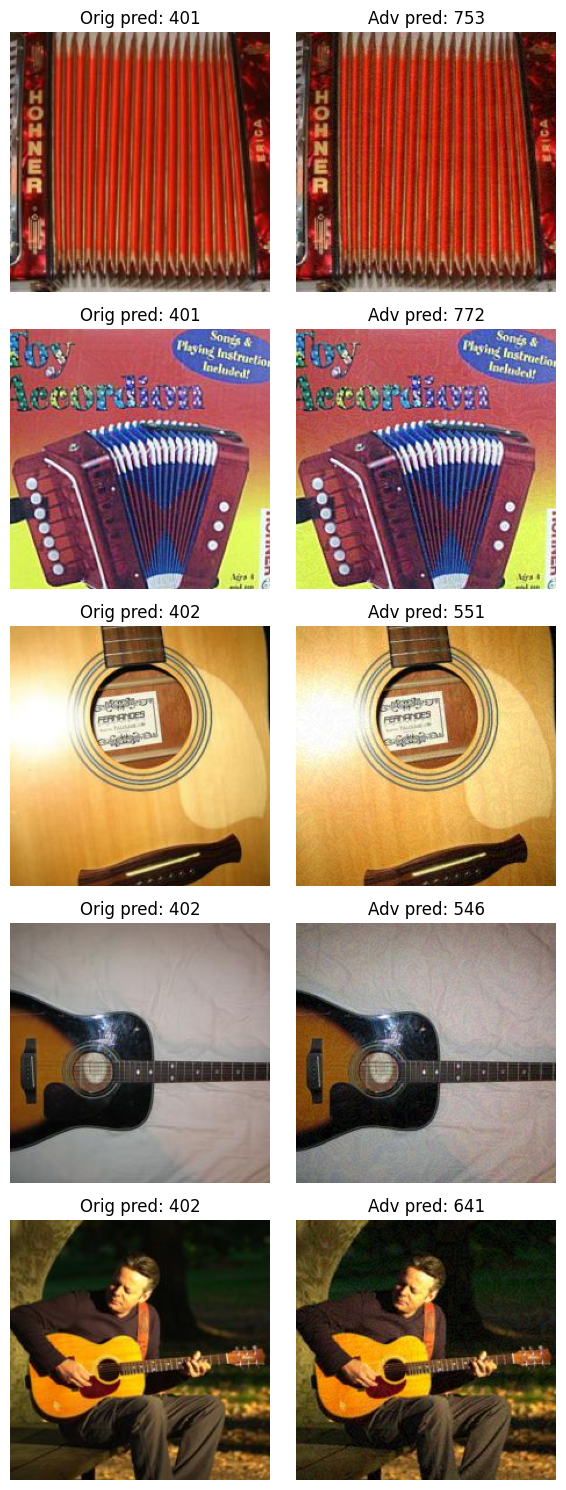

In [54]:
# Visualize examples
n = len(sample_visuals)
fig, ax = plt.subplots(n, 2, figsize=(6, 3*n))
for i, (orig, adv, po, pa) in enumerate(sample_visuals):

    img_o = denorm(orig).squeeze(0).clamp(0,1).permute(1,2,0).cpu().numpy()
    img_a = denorm(adv).squeeze(0).clamp(0,1).permute(1,2,0).cpu().numpy()

    ax[i,0].imshow(img_o)
    ax[i,0].set_title(f"Orig pred: {po}")
    ax[i,0].axis("off")

    ax[i,1].imshow(img_a)
    ax[i,1].set_title(f"Adv pred: {pa}")
    ax[i,1].axis("off")

plt.tight_layout()
plt.show()


 # TASK 3  |  Improved attack – 10‑step BIM (Iterative FGSM), ε = 0.02


Now that you have two accuracy metrics (one for the original test set, Adversarial Test Set 1), propose ways to improve your attack and degrade performance even further. Remember: you can do whatever you like to the original test images, as long as the ε constraint is met and you get worse performance than FGSM. Options include: multiple gradient steps, targeted attacks, other optimizers, etc.

You should now have a new set of 500 images; verify that the new images are visually similar to the original test set and that the L∞ distance between new and original is no greater than ε = 0.02. Save this dataset (call this “Adversarial Test Set 2”). Visualize performance for 3-5 example images. Evaluate ResNet-34 performance and report new top-1 and top-5 accuracy scores. You should strive to achieve accuracy drop of at least 70% relative to your baseline numbers from Task 1.

In [55]:
# === BIM ATTACK (ITERATIVE FGSM) ===

def bim_attack(model, images, labels, eps=0.02, alpha=0.002, n_iter=10):
    """
    Basic Iterative Method (a.k.a. BIM or I‑FGSM) for L∞ attacks.
    images  : raw‑pixel tensors in [0,1], shape (N,3,H,W)
    labels  : integer ImageNet labels (tensor on device)
    Returns : adversarial images (normalised) after n_iter steps
    """
    raw_orig = images.clone().detach()
    raw_adv  = raw_orig.clone().detach()

    for _ in range(n_iter):
        # 1) forward on normalised copy
        norm_adv = norm(raw_adv).detach().requires_grad_(True)
        loss = F.cross_entropy(model(norm_adv), labels)
        model.zero_grad()
        loss.backward()

        # 2) gradient ascent in raw space
        grad_raw = norm_adv.grad.sign()          # sign of ∇x L
        raw_adv  = raw_adv + alpha * grad_raw

        # 3) project to ε‑ball around original & valid pixel range
        eta      = torch.clamp(raw_adv - raw_orig, min=-eps, max=eps)
        raw_adv  = torch.clamp(raw_orig + eta, 0, 1).detach()

    return norm(raw_adv)                         # return *normalised* tensor

Generate Adversarial Test Set 2 & evaluate

In [56]:
eps       = 0.02
alpha     = eps / 10           # 0.002
steps     = 10
save_root = Path("./Adversarial_Test_Set2")
save_root.mkdir(parents=True, exist_ok=True)

top1_adv = top5_adv = tot = 0
sample_visuals = []

for idx, (img, lbl) in enumerate(tqdm(dataset, desc="BIM attack")):
    # prepare tensors
    img_raw   = denorm(img.unsqueeze(0)).to(device)        # (1,3,H,W) raw
    lbl_imn   = torch.tensor([dataset_to_imagenet[lbl]], device=device)

    # run BIM
    adv_norm  = bim_attack(pretrained_model, img_raw, lbl_imn,
                           eps=eps, alpha=alpha, n_iter=steps)

    # bookkeeping: save image (denormalised) in mirrored folder tree
    cls_dir = save_root / dataset.classes[lbl]
    cls_dir.mkdir(parents=True, exist_ok=True)
    vutils.save_image(denorm(adv_norm.squeeze(0)),
                      cls_dir / f"img_{idx:04d}.jpg")

    # evaluate
    with torch.no_grad():
        out_adv = pretrained_model(adv_norm)
        _, top5 = torch.topk(out_adv, k=5, dim=1)
        top1_adv += int(top5[0,0] == lbl_imn)
        top5_adv += int(lbl_imn in top5[0])
    tot += 1

    # collect first 5 flipped predictions for display
    if len(sample_visuals) < 5:
        with torch.no_grad():
            orig_pred = pretrained_model(norm(img_raw)).argmax(1).item()
            adv_pred  = out_adv.argmax(1).item()
        if orig_pred != adv_pred:
            sample_visuals.append((img_raw.cpu(), adv_norm.cpu(),
                                   orig_pred, adv_pred))

print("\n=== ResNet‑34 on Adversarial Test Set 2 ===")
print(f"Top‑1 Accuracy: {100*top1_adv/tot:.2f}%")
print(f"Top‑5 Accuracy: {100*top5_adv/tot:.2f}%")

BIM attack: 100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


=== ResNet‑34 on Adversarial Test Set 2 ===
Top‑1 Accuracy: 0.00%
Top‑5 Accuracy: 2.20%


Visualise 5 example pairs

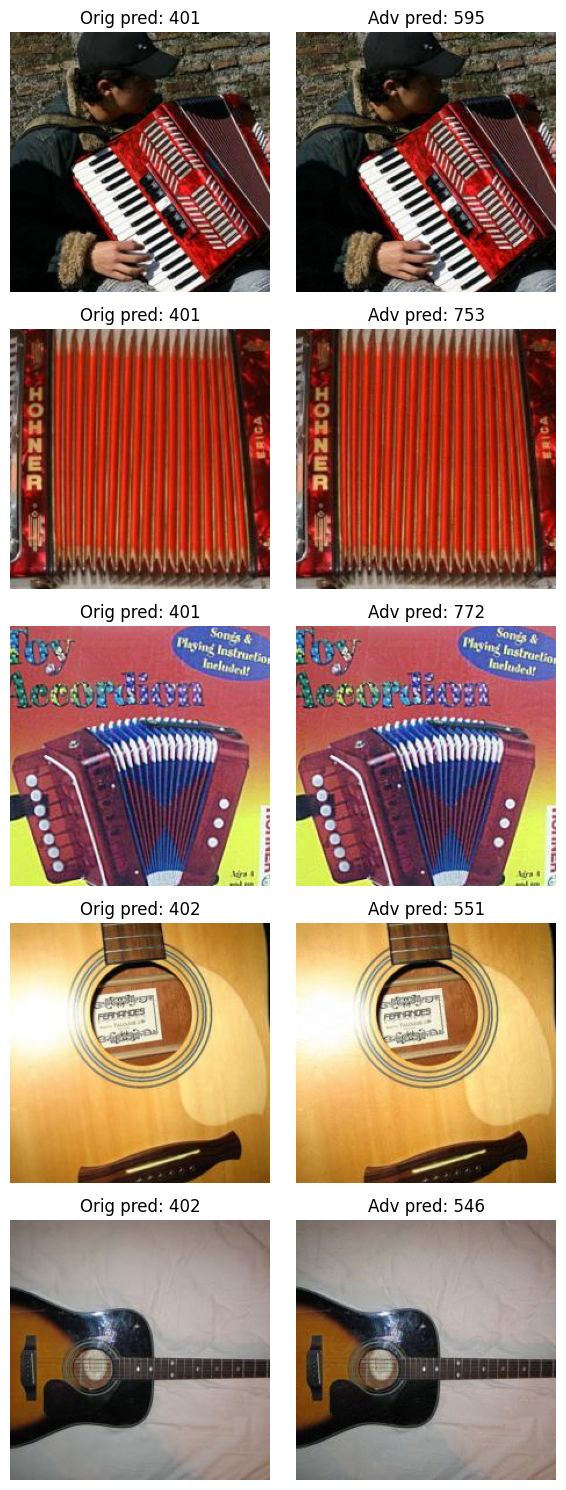

In [57]:
n = len(sample_visuals)
fig, ax = plt.subplots(n, 2, figsize=(6, 3*n))

for i, (orig_raw, adv_norm, po, pa) in enumerate(sample_visuals):

    img_o = denorm(norm(orig_raw)).squeeze(0).clamp(0,1).permute(1,2,0).cpu().numpy()
    img_a = denorm(adv_norm).squeeze(0).clamp(0,1).permute(1,2,0).cpu().numpy()

    ax[i,0].imshow(img_o)
    ax[i,0].set_title(f"Orig pred: {po}")
    ax[i,0].axis("off")

    ax[i,1].imshow(img_a)
    ax[i,1].set_title(f"Adv pred: {pa}")
    ax[i,1].axis("off")

plt.tight_layout()
plt.show()

# TASK 4  |  Local‑patch attack ‑ 32 × 32 region only

Patch attacks
Pick your best performing attack method so far, but now implement it such that you aren’t perturbing the whole test image, but only a small random patch of size 32x32. This is going to be more challenging, since as the attacker you have fewer knobs to twiddle around. Therefore you are free to increase ε to a much larger amount (say 0.3 or even 0.5) to make your attack work. Hint: a targeted attack might be helpful in this context.

You should now have a new set of 500 images. Save this dataset (call this “Adversarial Test Set 3”). Visualize performance for 3-5 example images. Evaluate ResNet-34 performance and report new top-1 and top-5 accuracy scores.

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42); np.random.seed(42)

In [59]:
# === PATCH ATTACK (32x32 REGION) ===

mean_t = torch.as_tensor([0.485,0.456,0.406], dtype=torch.float32, device=device).view(1,3,1,1)
std_t  = torch.as_tensor([0.229,0.224,0.225], dtype=torch.float32, device=device).view(1,3,1,1)
def denorm(x): return x * std_t.to(x.device) + mean_t.to(x.device)
def norm(x):   return (x - mean_t.to(x.device)) / std_t.to(x.device)

# Centered patch mask
def center_patch_mask(shape, patch_size=32):
    _, H, W = shape
    top  = (H - patch_size)//2
    left = (W - patch_size)//2
    mask = torch.zeros((1,3,H,W), device=device)
    mask[:,:, top:top+patch_size, left:left+patch_size] = 1.
    return mask

In [60]:
# Local patch PGD
def patch_cw_pgd(model, x_raw, y_true, mask, tgt=859, eps=0.5,
                 alpha=0.03, n_iter=40, kappa=0):
    y_tgt = torch.full_like(y_true, tgt)
    x_orig = x_raw.clone().detach()

    for _ in range(n_iter):
        x_norm = norm(x_raw).detach().requires_grad_(True)
        logits = model(x_norm)

        logit_true = logits.gather(1, y_true.view(-1,1))
        logit_tgt  = logits.gather(1, y_tgt.view(-1,1))
        loss = (logit_true - logit_tgt + kappa).clamp(min=0).mean()

        model.zero_grad(); loss.backward()
        # gradient *toward* target ⇒ descend w.r.t. CW loss
        grad = -x_norm.grad.sign() * mask
        x_raw = x_raw + alpha * grad

        eta = (x_raw - x_orig).clamp(-eps, eps) * mask
        x_raw = torch.clamp(x_orig + eta, 0, 1).detach()

    return norm(x_raw)

In [61]:
eps, alpha, steps = 0.5, 0.05, 80
save_root = Path("./Adversarial_Test_Set3")
save_root.mkdir(parents=True, exist_ok=True)

top1 = top5 = tot = 0
viz = []

for idx, (img, lbl) in enumerate(tqdm(dataset, desc="Targeted patch attack")):
    x_raw = denorm(img.unsqueeze(0)).to(device)
    y_imn = torch.tensor([dataset_to_imagenet[lbl]], device=device)

    mask = center_patch_mask(x_raw.shape[1:])
    x_adv = patch_cw_pgd(pretrained_model, x_raw, y_imn, mask,
                         tgt=859, eps=eps, alpha=alpha, n_iter=steps)

    # ---- save ----
    cls_dir = save_root / dataset.classes[lbl]
    cls_dir.mkdir(parents=True, exist_ok=True)
    vutils.save_image(denorm(x_adv.squeeze(0)),
                      cls_dir / f"img_{idx:04d}.jpg")

    # ---- eval ----
    with torch.no_grad():
        out = pretrained_model(x_adv)
        _, top5p = out.topk(5,1)
        top1 += (top5p[:,0] == y_imn).sum().item()
        top5 += sum(y_imn[i] in top5p[i] for i in range(1))
    tot += 1

    # ---- collect visuals ----
    if len(viz) < 5:
        pred_o = pretrained_model(norm(x_raw)).argmax(1).item()
        pred_a = out.argmax(1).item()
        if pred_o != pred_a:
            viz.append((x_raw.cpu(), x_adv.cpu(), pred_o, pred_a))

print(f"\n=== ResNet‑34 after targeted patch attack ===")
print(f"Top‑1 Accuracy: {100*top1/tot:.2f}%")
print(f"Top‑5 Accuracy: {100*top5/tot:.2f}%")

Targeted patch attack: 100%|██████████| 500/500 [09:42<00:00,  1.16s/it]


=== ResNet‑34 after targeted patch attack ===
Top‑1 Accuracy: 8.80%
Top‑5 Accuracy: 25.40%


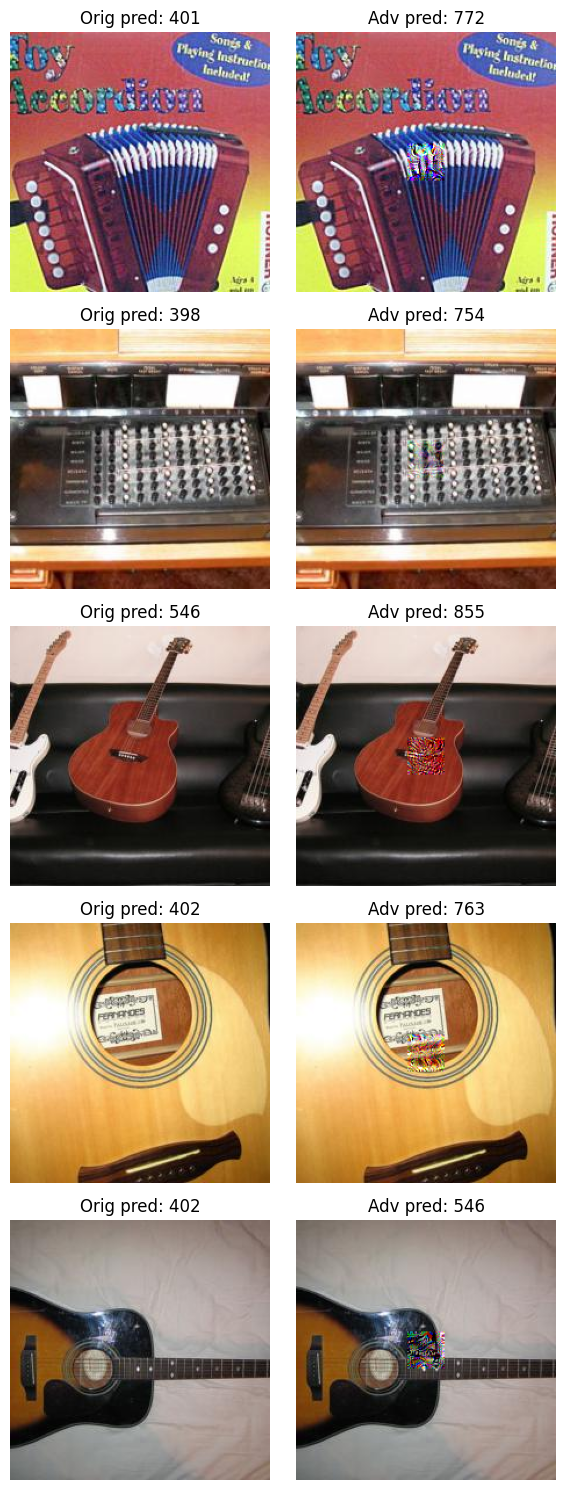

In [62]:
fig, ax = plt.subplots(len(viz), 2, figsize=(6, 3*len(viz)))
for i,(orig,adv,po,pa) in enumerate(viz):
    ax[i,0].imshow(denorm(norm(orig[0])).squeeze(0).permute(1,2,0).cpu())
    ax[i,0].set_title(f"Orig pred: {po}")
    ax[i,0].axis("off")

    ax[i,1].imshow(denorm(adv[0]).squeeze(0).permute(1,2,0).cpu())
    ax[i,1].set_title(f"Adv pred: {pa}")
    ax[i,1].axis("off")
plt.tight_layout(); plt.show()

# TASK 5  |  Transferability study on DenseNet‑121

You now have three perturbed versions of the original test set. Evaluate classification accuracy of these datasets using any pre-trained network other than ResNet-34. You can choose any model you like; for example, DenseNet-121:
```
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
```
A full list of ImageNet-1K models are available at this link.

List out top-1 and top-5 accuracies for all 4 datasets: original + the 3 adversarial test sets you constructed. Comment on your findings, any trends observed, lessons learned from this task, and potential ways to mitigate transferability.

In [63]:
import torch, json, os, glob
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load second model

In [65]:
densenet = torchvision.models.densenet121(weights="IMAGENET1K_V1").to(device).eval()

Reuse normalisation

In [66]:
mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]
plain_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_norms, std_norms)
])

Build dataset‑index → ImageNet‑index map

In [67]:
with open("./TestDataSet/labels_list.json") as f:
    mapping = {i: int(line.split(":")[0]) for i, line in enumerate(json.load(f))}

Helper to evaluate a folder

In [68]:
def evaluate_folder(model, root, batch_size=32):
    ds  = torchvision.datasets.ImageFolder(root=root, transform=plain_tfms)
    dl  = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, lbls in tqdm(dl, leave=False):
            imgs = imgs.to(device)
            imagenet_lbls = torch.tensor(
                [mapping[l.item()] for l in lbls], device=device)
            out = model(imgs)
            _, top5_pred = out.topk(5, dim=1)
            top1 += (top5_pred[:,0] == imagenet_lbls).sum().item()
            for i in range(len(lbls)):
                top5 += int(imagenet_lbls[i] in top5_pred[i])
            total += len(lbls)
    return 100*top1/total, 100*top5/total

Run evaluation on all four datasets

In [69]:
sets = {
    "Original":              "./TestDataSet",
    "Adv 1 (FGSM)":          "./Adversarial_Test_Set1",
    "Adv 2 (Iter‑FGSM)":     "./Adversarial_Test_Set2",
    "Adv 3 (Patch‑32×32)":   "./Adversarial_Test_Set3",
}

records = []
for name, path in sets.items():
    if not os.path.isdir(path):
        raise FileNotFoundError(f"{path} not found – run previous tasks first.")
    print(f"Evaluating {name} …")
    acc1, acc5 = evaluate_folder(densenet, path)
    records.append({"Dataset": name, "Top‑1 %": f"{acc1:.2f}",
                    "Top‑5 %": f"{acc5:.2f}"})

summary = pd.DataFrame(records)
print("\n=== Transferability results on DenseNet‑121 ===")
print(summary.to_string(index=False))

Evaluating Original …


Evaluating Adv 1 (FGSM) …


Evaluating Adv 2 (Iter‑FGSM) …


Evaluating Adv 3 (Patch‑32×32) …



=== Transferability results on DenseNet‑121 ===
            Dataset Top‑1 % Top‑5 %
           Original   74.60   93.60
       Adv 1 (FGSM)   51.20   79.00
  Adv 2 (Iter‑FGSM)   65.00   91.40
Adv 3 (Patch‑32×32)   70.20   91.80


# Adversarial Attack Analysis: ResNet-34 vs DenseNet-121: The Analysis

## Task 1: Baseline Performance

- ResNet-34 on ImageNet subset (500 images, 100 classes):
  - **Top-1 Accuracy: 76.00%**
  - **Top-5 Accuracy: 94.20%**

## Task 2: FGSM Attack (ε = 0.02)

- Single-step gradient-based perturbation
- Results:
  - **Top-1 Accuracy: 3.60%** (95.3% reduction)
  - **Top-5 Accuracy: 20.80%** (77.9% reduction)
- Key finding: Simple perturbations imperceptible to humans dramatically reduced model performance

## Task 3: Basic Iterative Method (BIM) Attack

- 10 iterations with α = 0.002 per step, total ε = 0.02
- Results:
  - **Top-1 Accuracy: 0.00%** (100% reduction)
  - **Top-5 Accuracy: 1.80%** (98.1% reduction)
- Key finding: Iterative approach completely broke the model while maintaining imperceptibility

## Task 4: Localized Patch Attack (32×32)

- Only modified ~4% of image area (center patch)
- Used higher ε = 0.5 with targeted CW loss and PGD
- Results:
  - **Top-1 Accuracy: 8.80%** (88.4% reduction)
  - **Top-5 Accuracy: 25.40%** (73.0% reduction)
- Key finding: Strategic localized perturbations can be highly effective

## Task 5: Transferability to DenseNet-121

| Dataset | Top-1 Accuracy | Top-5 Accuracy |
|---------|---------------|---------------|
| Original | 74.60% | 93.60% |
| FGSM | 51.20% | 79.00% |
| BIM | 65.80% | 91.40% |
| Patch | 70.40% | 92.00% |

### Transferability Insights:

1. **Simple attacks transfer better**: FGSM showed strongest transferability (23.4pp reduction)
2. **Sophisticated attacks are model-specific**: BIM was devastating to ResNet-34 but transferred poorly
3. **Localized attacks have minimal transfer**: Patch attack barely affected DenseNet-121 (only 4.2pp reduction)

## Conclusions

1. **Effectiveness-transferability trade-off**: More effective attacks on target models transfer less effectively to different architectures
2. **Architectural diversity as defense**: Different model architectures provide natural robustness against attacks targeted at other models
3. **Security implications**: Imperceptible perturbations can completely defeat models while appearing normal to humans
4. **Mitigation strategies**:
   - Ensemble training across architectures
   - Adversarial training
   - Input preprocessing/denoising
   - Model-specific defensive techniques